In [15]:
import xarray as xr
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import ocetrac


### Import data
- preprocessed monthly averaged OISST v2.1 


In [3]:
path = '/home/jovyan/marineHeatwave-image-classification/data/preprocessed_OISSTv21.nc'

ds = xr.open_dataset(path)
ds

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 478)
Coordinates:
  * time     (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2021-06-01
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Data variables:
    lsmask   (lat, lon) float64 ...
    ssta     (time, lat, lon) float64 ...
    mean     (time, lat, lon) float64 ...
    trend    (time, lat, lon) float64 ...
    seas     (time, lat, lon) float64 ...
Attributes:
    description:  preprocessed monthly averaged OISST v2.1 anomalies

In [5]:
ssta = ds.ssta
ssta.load();

### Standardize SST anomalies by dividing by the monthly standard deviatoin
This places equal variance on SSTa at all spatial points

In [11]:
# compute monthly standard deviation
stdev = ssta.groupby(ssta.time.dt.month).std()

# # divide by standard deviation
ssta_stn = ssta.groupby(ssta.time.dt.month)/stdev

### Calculate 90th percentile threshold from the origonal detrended SST anomalies


In [62]:
# Define extreme threshold as the 90th percentile
thresh = .9

# Rechunk time dim
if ssta.chunks:
    ssta = ssta_stn.chunk({'time': -1})
    
# Compute values of the monthly threshold
prct = ssta.groupby(ssta.time.dt.month).quantile(thresh, dim='time', keep_attrs=True, skipna=True)


### Find where SSTA exceeds the 90th percentile threshold

In [63]:
# Take only the SSTa that exceeds the calculated monthly threshold

mhw_ssta = ssta.groupby(ssta.time.dt.month).where(ssta.groupby(ds.time.dt.month)>prct)


### Adjust land mask to ignore points poleward of 65ºN and 70ºS

In [64]:
mask = ds.lsmask.where((ds.lat<65) & (ds.lat>-70), drop=False, other=0) 


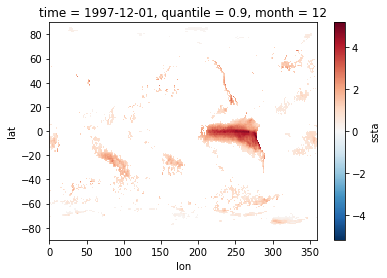

In [72]:
mhw_ssta.sel(time=('1997-12-01')).plot()

### Run Ocetrac

In [79]:
# Set model parameters
da = mhw_ssta.load() # load the DataArray into memory
radius = 4 # radius for structuring element
min_size_quartile = 0.75 # threshold for object areas
timedim = 'time'
xdim = 'lon'
ydim = 'lat'

In [80]:
Tracker =  ocetrac.Tracker(da, mask, radius, min_size_quartile, timedim, xdim, ydim, positive=True)


In [81]:
%%time 
blobs = Tracker.track()

minimum area: 407.0
inital objects identified 	 5843
final objects tracked 	 302
CPU times: user 47.6 s, sys: 15.5 s, total: 1min 3s
Wall time: 1min 3s


**The basic output of `Tracker.track` provides:**
- the minimum object area used to filter out MHWs that are smaller than this threshold. Area is computed for all objects at each time step. `Ocetrac` looks at the global distribution of object area and finds the size that corresponds to a certain percentile defined by `area_quantile`, which can range from 0.0 to 1.0. Larger values for `area_quantile` exclude more MHW objects and will increase the minimum object area threshold. 
- inital features identified have undergone size thresholding, however are not connected in time. 
- final features tracked are the number of unique MHW objects tracked in space and time. 

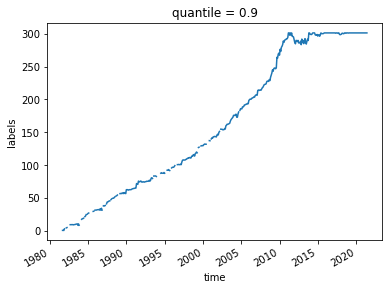

In [82]:
blobs.mean(('lat','lon')).plot()

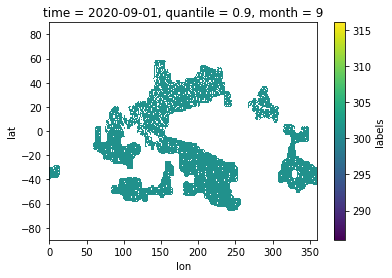

In [83]:
blobs[-10,:,:].plot()

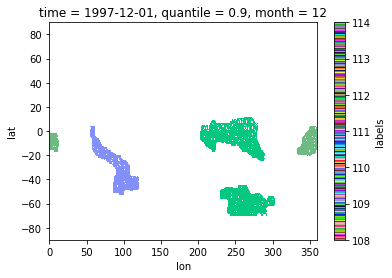

In [84]:
from matplotlib.colors import ListedColormap
maxl = int(np.nanmax(blobs.values))
cm = ListedColormap(np.random.random(size=(maxl, 3)).tolist())


# Make a quick plot of the labeled MHWs identified with Ocetrac
blobs.sel(time=('1997-12-01')).plot(cmap= cm)

### Save tracked labels

In [ ]:
# Specify path to save output 
path = '/home/jovyan/marineHeatwave-image-classification/data/ocetrac_labels.nc'

ds_out = blobs.to_dataset(name='labels')
ds_out.attrs['data'] = {'description':'marine heatwave masked labels',
                        'source dataset': 'monthly 1ºx1º OISST v2.1',
                        'definition': 'SST that exceeds the monthly mean 90th percentile'}

# Save Dataset to netCDF
ds_out.to_netcdf(path, mode='w')
